# Endpoint Performance: Endpoint Peering

The goal of this experiment is to understand the latency and bandwidth between endpoints issuing requests to peer endpoints.
We compare to using a Redis server with SSH tunnels as an alternative.

## Instructions

### Setup

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```
2. Configure a ProxyStore endpoint on the local and remote systems.
   ```bash
   $ proxystore-endpoint configure psbench
   $ proxystore-endpoint start psbench &> /dev/null &
   ```
   Note: endpoint logs will still be written to ~/.proxystore
   
### Run

```bash
$ python -m psbench.benchmarks.remote_ops \
      REDIS \
      --redis-host thetalogin5 \
      --redis-port 59465 \
      --ops GET SET EXISTS EVICT \
      --payload-sizes 1000 10000 100000 1000000 10000000 \
      --repeat 5 \
      --csv-file results/thetalogin4-thetalogin5-remote-ops.csv
      
$ python -m psbench.benchmarks.remote_ops \
      ENDPOINT \
      --endpoint {ENDPOINT UUID} \
      --server {SIGNALING SERVER URL } \
      --ops GET SET EXISTS EVICT \
      --payload-sizes 1000 10000 100000 1000000 10000000 \
      --repeat 5 \
      --csv-file results/thetalogin4-thetalogin5-remote-ops.csv
```

### Notes:
- N/A

In [1]:
%matplotlib inline

import math
from typing import Any

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy
import seaborn

# to change default colormap
plt.rcParams["image.cmap"] = "tab10"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [2]:
BACKEND_COLUMN = 'backend'
OP_COLUMN = 'op'
PAYLOAD_COLUMN = 'payload_size_bytes'
AVG_TIME_COLUMN = 'avg_time_ms'
MIN_TIME_COLUMN = 'min_time_ms'
MAX_TIME_COLUMN = 'max_time_ms'

def load(filepath: str) -> pandas.DataFrame:
    return pandas.read_csv(filepath)

In [3]:
theta_data = load('data/3-endpoint-performance-peering/thetalogin4-thetalogin5-remote-ops.csv')
midway_data = load('data/3-endpoint-performance-peering/midway2-thetalogin5-remote-ops.csv')
frontera_data = load('data/3-endpoint-performance-peering/frontera-thetalogin5-remote-ops.csv')
theta_data.head()

,backend,op,payload_size_bytes,repeat,total_time_ms,avg_time_ms,min_time_ms,max_time_ms,avg_bandwidth_mbps
0,REDIS,GET,1000.0,5,0.679763,0.226588,0.203647,0.242440,4.413303
1,REDIS,GET,10000.0,5,0.466390,0.155463,0.129955,0.190086,64.323849
2,REDIS,GET,100000.0,5,0.707540,0.235847,0.191786,0.260782,424.004297
3,REDIS,GET,1000000.0,5,2.408085,0.802695,0.730678,0.910145,1245.803200
4,REDIS,GET,10000000.0,5,27.453748,9.151249,8.295218,9.902027,1092.746972


In [4]:
def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def get_value_by_other_column(data: pandas.DataFrame, query_column: str, query_value: Any, target_column: str) -> Any:
    rows = data.loc[data[query_column] == query_value]
    assert len(rows) == 1
    return rows[target_column].values[0]

In [5]:
DATA = {
    'Theta → Theta': theta_data,
    'Campus Cluster → Theta': midway_data,
    'Frontera → Theta': frontera_data,
}
F_STR = '{system:22} | {op:6} | {size:<9} | {avg_endpoint:8.3f} | {avg_redis:8.3f}'

print('                                |  Payload  |  Avg Op Time (ms)')
print('Systems                | Op     |   Bytes   | Endpoint |  Redis')

for systems, data in DATA.items():
    print('-----------------------|--------|-----------|----------|---------')
    for op in ['GET', 'SET', 'EVICT', 'EXISTS']:
        op_data = rows_matching_column_value(data, OP_COLUMN, op)
        endpoint_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'ENDPOINT')
        redis_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'REDIS')
        if op in ['GET', 'SET']:
            for payload_size in list(op_data[PAYLOAD_COLUMN].unique()):
                avg_endpoint = get_value_by_other_column(endpoint_data, PAYLOAD_COLUMN, payload_size, AVG_TIME_COLUMN)
                avg_redis = get_value_by_other_column(redis_data, PAYLOAD_COLUMN, payload_size, AVG_TIME_COLUMN)
                print(F_STR.format(system=systems, op=op, size=int(payload_size), avg_endpoint=avg_endpoint, avg_redis=avg_redis))
        else:
            avg_endpoint = get_value_by_other_column(endpoint_data, OP_COLUMN, op, AVG_TIME_COLUMN)
            avg_redis = get_value_by_other_column(redis_data, OP_COLUMN, op, AVG_TIME_COLUMN)
            print(F_STR.format(system=systems, op=op, size='N/A', avg_endpoint=avg_endpoint, avg_redis=avg_redis))

                                |  Payload  |  Avg Op Time (ms)
Systems                | Op     |   Bytes   | Endpoint |  Redis
-----------------------|--------|-----------|----------|---------
Theta → Theta          | GET    | 1000      |    1.605 |    0.227
Theta → Theta          | GET    | 10000     |    1.987 |    0.155
Theta → Theta          | GET    | 100000    |    7.639 |    0.236
Theta → Theta          | GET    | 1000000   |   68.930 |    0.803
Theta → Theta          | GET    | 10000000  |  608.133 |    9.151
Theta → Theta          | SET    | 1000      |    1.620 |    0.155
Theta → Theta          | SET    | 10000     |    2.113 |    0.167
Theta → Theta          | SET    | 100000    |    7.925 |    0.182
Theta → Theta          | SET    | 1000000   |   72.135 |    0.744
Theta → Theta          | SET    | 10000000  |  611.600 |    6.503
Theta → Theta          | EVICT  | N/A       |    1.381 |    0.106
Theta → Theta          | EXISTS | N/A       |    1.434 |    0.158
--------------

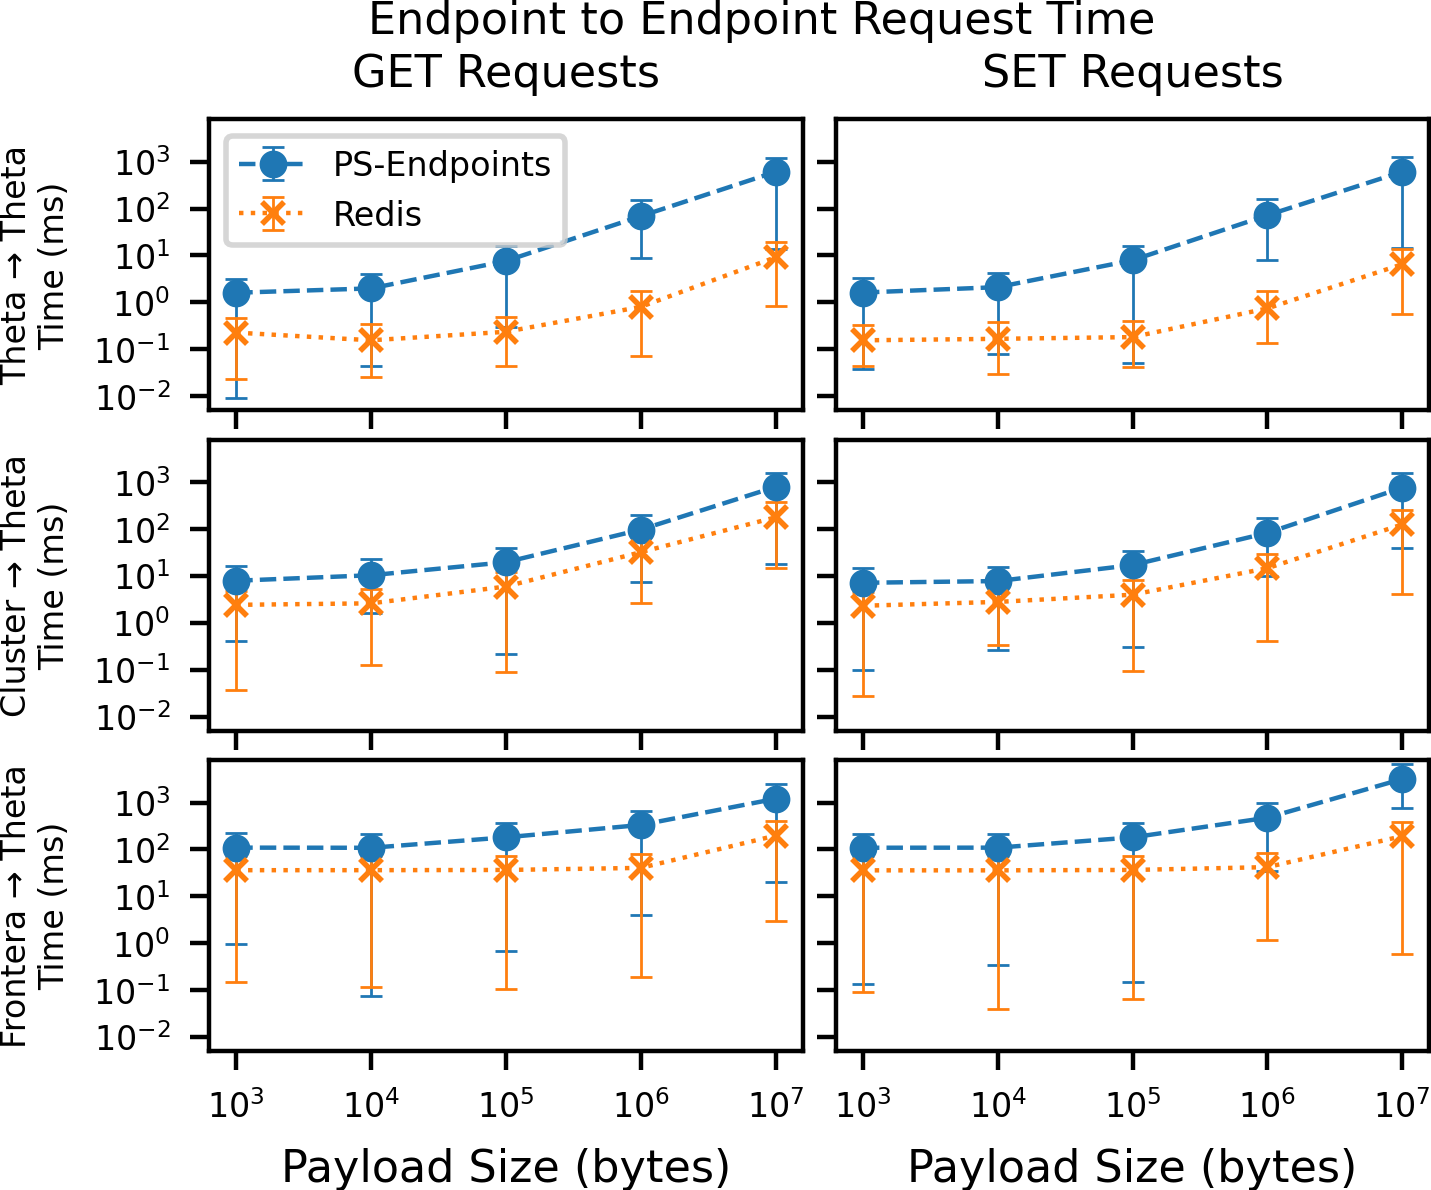

In [7]:
MARKERS = ('o', 'x')
LINES = ('--', ':')

payload_labels = ['1 KB', '10 KB', '100 KB', '1 MB', '10 MB']

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

for i, (systems, data) in enumerate(DATA.items()):

    for j, op in enumerate(('GET', 'SET')):
        ax = axs[i, j]
        ax.set_yscale('log', base=10)
        ax.set_xscale('log', base=10)
        ax.set_xticks([1e3, 1e4, 1e5, 1e6, 1e7])
    
        op_data = rows_matching_column_value(data, OP_COLUMN, op)
        endpoint_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'ENDPOINT')
        redis_data = rows_matching_column_value(op_data, BACKEND_COLUMN, 'REDIS')
    
        for k, (name, series) in enumerate((('PS-Endpoints', endpoint_data), ('Redis' ,redis_data))):
            ax.errorbar(
                series[PAYLOAD_COLUMN],
                series[AVG_TIME_COLUMN],
                yerr=numpy.stack([series[MIN_TIME_COLUMN], series[MAX_TIME_COLUMN]]),
                marker=MARKERS[k],
                label=f'{name}',
                linestyle=LINES[k],
                capsize=2,
                elinewidth=0.5,
                capthick=0.5,
            )


fig.suptitle('Endpoint to Endpoint Request Time')
for i, systems in enumerate(DATA):
    systems = systems if not systems.startswith('Campus') else systems.replace('Campus ', '')
    axs[i, 0].set_ylabel(f'{systems}\nTime (ms)', fontsize=6)
axs[0, 0].set_title('GET Requests')
axs[0, 1].set_title('SET Requests')
axs[-1, 0].set_xlabel('Payload Size (bytes)')
axs[-1, 1].set_xlabel('Payload Size (bytes)')

# Use integer x labels instead of powers of 2
plt.yticks([0.01, 0.1, 1, 10, 100, 1000])
plt.ylim([0.005, 8000])
plt.minorticks_off()

axs[0, 0].legend(loc='upper left')

fig.tight_layout(h_pad=.5, w_pad=0.75)

fig.set_size_inches(3.5, 3)
plt.savefig('figures/endpoint-times-remote.png', pad_inches=0.05)